## 사용 패키지

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import math
import os
import gc
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tqdm import tqdm

## 데이터

In [3]:
path = '/content/drive/MyDrive/security/'

In [4]:
train = pd.read_csv(path+'train.csv')
test = pd.read_csv(path+'test.csv')
submission = pd.read_csv(path+'sample_submission.csv')

In [5]:
train.head()

,id,level,full_log
0,0,0,"Sep 24 10:02:22 localhost kibana: {""type"":""err..."
1,1,0,Feb 8 16:21:00 localhost logstash: [2021-02-0...
2,2,0,"Jan 13 01:50:40 localhost kibana: {""type"":""err..."
3,3,0,"Jan 4 10:18:31 localhost kibana: {""type"":""err..."
4,4,1,type=SYSCALL msg=audit(1603094402.016:52981): ...


In [6]:
test.head()

,id,full_log
0,1000000,"Feb 8 15:47:26 localhost kibana: {""type"":""err..."
1,1000001,"Sep 24 03:46:39 localhost kibana: {""type"":""err..."
2,1000002,type=SYSCALL msg=audit(1611888200.428:210563):...
3,1000003,"Jan 18 11:24:06 localhost kibana: {""type"":""err..."
4,1000004,type=SYSCALL msg=audit(1603081202.050:46851): ...


## EDA

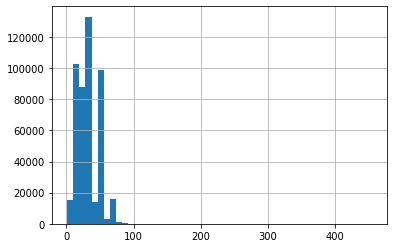

In [7]:
train['full_log'].str.split(' ').str.len().hist(bins=50)

In [8]:
submission.head()

,id,level
0,1000000,0
1,1000001,0
2,1000002,0
3,1000003,0
4,1000004,0


In [9]:
train['level'].value_counts()

0    334065
1    132517
3      4141
5      2219
2        12
4        10
6         8
Name: level, dtype: int64

In [10]:
text_train, text_val, label_train, label_val = train_test_split(train['full_log'], train['level'], test_size=0.2, random_state=42)

In [11]:
label_train.value_counts()

0    267279
1    105970
3      3340
5      1766
2        10
4         7
6         5
Name: level, dtype: int64

In [12]:
label_val.value_counts()

0    66786
1    26547
3      801
5      453
6        3
4        3
2        2
Name: level, dtype: int64

## 전처리

숫자를 모두 num으로 치환하여 단어 수를 줄였습니다.

In [13]:
text_train = text_train.str.replace(r'[0-9]', '<num>')
text_val = text_val.str.replace(r'[0-9]', '<num>')

## 토큰화

In [14]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(text_train)
top_k = len(tokenizer.word_index)

x_train = tokenizer.texts_to_sequences(text_train)
x_val = tokenizer.texts_to_sequences(text_val)

max_length=320

x_train_vector = tf.keras.preprocessing.sequence.pad_sequences(
    x_train, maxlen=max_length, padding='post'
)

x_val_vector = tf.keras.preprocessing.sequence.pad_sequences(
    x_val, maxlen=max_length, padding='post'
)

## 하이퍼파라미터

Attention Is All You Need 논문에서 제시한 하이퍼파라미터를 사용하였습니다.

RTX 3090 (24g) GPU로 학습하였으며 colab GPU 환경에서 작동 여부는 확인하지 못하였습니다.

colab OOM 발생시 튜닝하여 사용 가능합니다.

참고 - https://arxiv.org/abs/1706.03762

In [15]:
BATCH_SIZE = 8
EPOCHS = 5
num_layers = 6
dff = 2048
num_heads =  8
dropout_rate = 0.1
d_model = 512
vocab_size = top_k+1
label_num = 7

## 학습 및 검증 데이터셋

In [16]:
def map_func(seq, label):
    return seq, label

In [17]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_vector, label_train))
train_dataset = train_dataset.map(map_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((x_val_vector, label_val))
val_dataset = val_dataset.map(map_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [18]:
next(iter(train_dataset))[0].shape, next(iter(train_dataset))[1].shape, next(iter(val_dataset))[0].shape, next(iter(val_dataset))[1].shape

(TensorShape([8, 320]),
 TensorShape([8]),
 TensorShape([8, 320]),
 TensorShape([8]))

## 모델 정의

Transformer의 Encoder에 출력 layer를 추가하여 분류 모델을 만들었습니다.

참고 - https://www.tensorflow.org/tutorials/text/transformer

In [19]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

In [20]:
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

In [21]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

    # add extra dimensions to add the padding
    # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [22]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

In [23]:
def scaled_dot_product_attention(q, k, v, mask):
    """Calculate the attention weights.
    q, k, v must have matching leading dimensions.
    k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
    The mask has different shapes depending on its type(padding or look ahead) 
    but it must be broadcastable for addition.

    Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.

    Returns:
    output, attention_weights
    """

    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

In [24]:
def print_out(q, k, v):
    temp_out, temp_attn = scaled_dot_product_attention(q, k, v, None)
    print ('Attention weights are:')
    print (temp_attn)
    print ('Output is:')
    print (temp_out)

In [25]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

        return output, attention_weights

In [26]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
        tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
    ])

In [27]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):

        attn_output, attention_weight = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

        return out2, attention_weight

In [28]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                                self.d_model)


        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)

        self.final_layer = tf.keras.layers.Dense(label_num)

    def call(self, x, training, mask):
    
        seq_len = tf.shape(x)[1]

        # adding embedding and position encoding.
        x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, attention_weight = self.enc_layers[i](x, training, mask)

        x = tf.keras.layers.Flatten()(x)

        x = self.final_layer(x)

        return x, attention_weight  # (batch_size, label_num)

## 학습률 스케쥴러

CosineAnealing을 스케쥴러로 사용하였으나 1cycle만 학습하여 학습 과정에서 학습률 증가 구간은 없습니다.

In [29]:
class CosineAnnealingLearningRateSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, t_batch, lr_max, lr_min, n_cycle):
        self.t_batch = t_batch
        self.lr_max = lr_max
        self.lr_min = lr_min
        self.n_cycle = n_cycle
    
    def __call__(self, step):
        cos_inner = (math.pi * (step % (self.t_batch*self.n_cycle))) / (self.t_batch*self.n_cycle)
        
        return (self.lr_max - self.lr_min)/2 * (tf.math.cos(cos_inner) + 1) + self.lr_min

In [30]:
max_rate = 1e-5
min_rate = 1e-6
cycle = 5

Text(0.5, 0, 'Train Step')

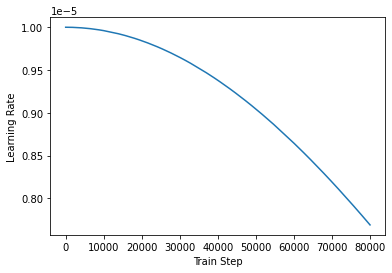

In [31]:
temp_learning_rate_schedule = CosineAnnealingLearningRateSchedule(len(x_train_vector)//BATCH_SIZE+1, max_rate, min_rate, cycle)

plt.plot(temp_learning_rate_schedule(tf.range(80000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

## 샘플 모델

샘플 모델을 만들어 입/출력 형태를 확인합니다.

In [32]:
sample_encoder = Encoder(
    num_layers=num_layers, d_model=d_model, num_heads=num_heads, dff=dff,
    input_vocab_size=vocab_size, maximum_position_encoding=max_length, rate=dropout_rate
)

temp_input = next(iter(train_dataset))[0]

sample_encoder_output, attention_weight = sample_encoder(temp_input, training=False, mask=None)

print (sample_encoder_output.shape)

(8, 7)


## 모델 및 loss function

In [33]:
model = Encoder(
    num_layers=num_layers, d_model=d_model, num_heads=num_heads, dff=dff,
    input_vocab_size=vocab_size, maximum_position_encoding=max_length, rate=dropout_rate
)

learning_rate = CosineAnnealingLearningRateSchedule(len(x_train_vector)//BATCH_SIZE+1, max_rate, min_rate, cycle)
optimizer = tf.keras.optimizers.Adam(learning_rate)

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [34]:
@tf.function
def loss_function(real, pred):
    loss_ = loss_object(real, pred)

    return loss_

## 체크포인트 지정

In [35]:
checkpoint_path = './checkpoint/'
os.makedirs(checkpoint_path, exist_ok=True)
ckpt = tf.train.Checkpoint(
    captioning_transformer=model, 
    optimizer=optimizer
)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=25)

In [36]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print(ckpt_manager.latest_checkpoint)

## 학습 정의

In [37]:
@tf.function()
def train_step(seq, label, training=True):
    with tf.GradientTape() as tape:
        predictions,_ = model(seq, training=training, mask=None)
        loss = loss_object(label, predictions)

    if training==True:
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  
    return loss, predictions

In [38]:
gc.collect()

0

## 학습

In [39]:
loss_plot, val_loss_plot = [], []

In [40]:
for epoch in range(start_epoch, EPOCHS):
    total_loss, total_val_loss = 0, 0

    tqdm_dataset = tqdm(enumerate(train_dataset))

    for (batch, (seq, label)) in tqdm_dataset:
        batch_loss, pred_list = train_step(seq, label, training=True)
        total_loss += batch_loss.numpy().mean()

        tqdm_dataset.set_postfix({
            'Epoch': epoch + 1,
            'Loss': '{:06f}'.format(batch_loss.numpy().mean()),
            'Total Loss' : '{:06f}'.format(total_loss/(batch+1))
        })
        
    loss_plot.append(total_loss / (batch+1))

    tqdm_dataset_val = tqdm(enumerate(val_dataset))

    for (batch, (seq, label)) in tqdm_dataset_val:

        batch_val_loss, pred_list = train_step(seq, label, training=False)
        total_val_loss += batch_val_loss.numpy().mean()

        tqdm_dataset_val.set_postfix({
            'Epoch': epoch + 1,
            'Val Loss': '{:06f}'.format(batch_val_loss.numpy().mean()),
            'Val Total_Loss' : '{:06f}'.format(total_val_loss/(batch+1))
        })

    val_loss_plot.append(total_val_loss / (batch+1))

    if np.min(val_loss_plot) == val_loss_plot[-1]:
        ckpt_manager.save()

47298it [1:21:18,  9.70it/s, Epoch=1, Loss=0.000000, Total Loss=0.022042]
11825it [05:35, 35.25it/s, Epoch=1, Val Loss=0.000000, Val Total_Loss=0.009388]
47298it [1:22:29,  9.56it/s, Epoch=2, Loss=0.000000, Total Loss=0.008147]
11825it [05:32, 35.53it/s, Epoch=2, Val Loss=0.000000, Val Total_Loss=0.008784]
47298it [1:22:17,  9.58it/s, Epoch=3, Loss=0.000001, Total Loss=0.006070]
11825it [05:32, 35.58it/s, Epoch=3, Val Loss=0.000000, Val Total_Loss=0.007232]
47298it [1:22:52,  9.51it/s, Epoch=4, Loss=0.000000, Total Loss=0.004717]
11825it [05:32, 35.59it/s, Epoch=4, Val Loss=0.000000, Val Total_Loss=0.007653]
47298it [1:23:01,  9.49it/s, Epoch=5, Loss=0.000000, Total Loss=0.004359]
11825it [05:41, 34.59it/s, Epoch=5, Val Loss=0.000000, Val Total_Loss=0.005141]


## 학습 결과

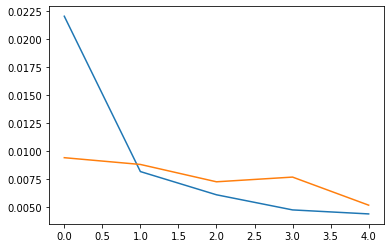

In [41]:
plt.plot(loss_plot)
plt.plot(val_loss_plot)
plt.show()

## 검증 결과가 가장 좋았던 체크포인트로 복원

In [42]:
ckpt.restore(ckpt_manager.latest_checkpoint)

In [43]:
ckpt_manager.latest_checkpoint

'./checkpoint/ckpt-4'

## 추론 정의

In [44]:
@tf.function
def predict(seq):
    predictions, attention_weight = model(seq, training=False, mask=None)
    predictions = tf.nn.softmax(predictions, axis=1)
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
    
    return predicted_id, predictions, attention_weight

## 검증셋 추론

In [45]:
preds = None
for seq, label in tqdm(val_dataset):
    if preds is None:
        preds, probas, _ = predict(seq)
        true = label
    else:
        pred, proba, _ = predict(seq)
        preds = tf.concat([preds, pred], axis=-1)
        probas = tf.concat([probas, proba], axis=0)
        true = tf.concat([true, label], axis=-1)

100%|██████████| 11825/11825 [05:24<00:00, 36.47it/s]


## 검증셋 Confusion Matrix

In [46]:
ct = pd.crosstab(true.numpy(), preds.numpy(), rownames=['real'], colnames=['pred'])
ct

pred,0,1,2,3,4,5
real,,,,,,
0,66783,0,0,2,0,1
1,142,26405,0,0,0,0
2,0,0,2,0,0,0
3,2,0,0,799,0,0
4,0,0,0,0,3,0
5,15,0,0,0,0,438
6,1,0,0,2,0,0


## level 7 분류

level 7을 찾기위해 Threshold를 지정하여 검증셋 추론 결과 변화 확인합니다.

In [47]:
preds_numpy = preds.numpy()
preds_numpy[np.where(np.max(probas, axis=1) < 0.9)] = 7
print(np.sum(preds_numpy==7))
ct = pd.crosstab(true.numpy(), preds_numpy, rownames=['real'], colnames=['pred'])
ct

450


pred,0,1,2,3,4,5,7
real,,,,,,,
0,66488,0,0,0,0,1,297
1,4,26405,0,0,0,0,138
2,0,0,2,0,0,0,0
3,0,0,0,799,0,0,2
4,0,0,0,0,3,0,0
5,2,0,0,0,0,438,13
6,1,0,0,2,0,0,0


## Test데이터 추론

In [48]:
text_test = test['full_log'].str.replace(r'[0-9]', '<num>')

x_test = tokenizer.texts_to_sequences(text_test)

x_test_vector = tf.keras.preprocessing.sequence.pad_sequences(
   x_test , maxlen=max_length, padding='post'
)

In [49]:
test_dataset = tf.data.Dataset.from_tensor_slices((x_test_vector))
test_dataset = test_dataset.batch(256)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [50]:
preds = None
for seq in tqdm(test_dataset):
    if preds is None:
        preds, probas, _ = predict(seq)
    else:
        pred, proba, _ = predict(seq)
        preds = tf.concat([preds, pred], axis=-1)
        probas = tf.concat([probas, proba], axis=0)

100%|██████████| 5543/5543 [1:05:35<00:00,  1.41it/s]


## level 7 검출

최대 예측률이 0.9 이하인 데이터를 level 7로 분류

In [51]:
preds_numpy = preds.numpy()
preds_numpy[np.where(np.max(probas, axis=1) < 0.9)] = 7
np.sum(preds_numpy==7)

6905

## 제출

In [52]:
submission['level'] = preds_numpy

In [55]:
submission.to_csv(path+'baseline_final.csv', index=False)